In [ ]:
!pip install librosa scikit-learn tensorflow kaggle


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade librosa


In [ ]:
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.6 MB/s eta 0:00:00


In [ ]:
from google.colab import files
files.upload()  # This will open a file selection dialog to upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mkdpahasara","key":"56d7ebf459ce9dcbcde1623be6f8ea5c"}'}

In [ ]:
import os
import json

# Make the .kaggle directory and move kaggle.json to it
os.makedirs('/root/.kaggle', exist_ok=True)

# Move the uploaded kaggle.json to the correct location
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

# Check the file exists
os.listdir('/root/.kaggle')


['kaggle.json']

In [ ]:
import kaggle

# Set your Kaggle API key if not set already
kaggle.api.authenticate()

# Download the dataset
dataset_path = "uwrfkaggler/ravdess-emotional-speech-audio"
kaggle.api.dataset_download_files(dataset_path, path="./", unzip=True)


Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio


In [ ]:
import os
import pandas as pd

# Define the path to the dataset folder
dataset_folder = "./"

# Create a dictionary to map emotions to binary labels
emotion_to_confidence = {
    1: "Confidence",  # Neutral
    2: "Confidence",  # Calm
    3: "Confidence",  # Happy
    4: "No Confidence",  # Sad
    5: "No Confidence",  # Angry
    6: "No Confidence",  # Fearful
    7: "No Confidence",  # Disgust
    8: "Confidence",  # Surprised
}

# Create an empty list to store the file data
file_data = []

# Traverse the dataset folder to gather file details
for root, dirs, files in os.walk(dataset_folder):
    for file in files:
        if file.endswith(".wav"):
            # Extract emotion from the filename
            parts = file.split("-")
            emotion = int(parts[2])
            confidence_label = emotion_to_confidence[emotion]

            # Append data as a dictionary
            file_data.append({
                "filename": os.path.join(root, file),
                "emotion": emotion,
                "confidence": confidence_label,
            })

# Convert the list into a Pandas DataFrame
ravdess_table = pd.DataFrame(file_data)

# Save as a CSV for future reference
ravdess_table.to_csv("ravdess_binary_classification.csv", index=False)

# Display the table
print(ravdess_table.head())


                              filename  emotion     confidence
0  ./Actor_13/03-01-03-02-02-01-13.wav        3     Confidence
1  ./Actor_13/03-01-07-01-01-01-13.wav        7  No Confidence
2  ./Actor_13/03-01-02-02-01-01-13.wav        2     Confidence
3  ./Actor_13/03-01-04-01-02-01-13.wav        4  No Confidence
4  ./Actor_13/03-01-06-01-01-01-13.wav        6  No Confidence


In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import resampy
import soundfile as sf

In [ ]:
import os
import numpy as np
import pandas as pd
import soundfile as sf  # Alternative for loading audio files
import librosa

def extract_features(file_path, n_mfcc=40):
    """Extract MFCC features from an audio file using soundfile."""
    try:
        # Read audio data and sample rate
        audio, sample_rate = sf.read(file_path)

        # Resample the audio if necessary
        if audio.ndim > 1:  # Stereo to mono conversion
            audio = np.mean(audio, axis=1)

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Load the labeled dataset
df = pd.read_csv("/content/ravdess_binary_classification.csv")

# Initialize lists to store features and labels
features = []
labels = []

for index, row in df.iterrows():
    file_path = row["filename"]
    confidence_label = 1 if row["confidence"] == "Confidence" else 0  # Binary label

    # Extract MFCCs
    mfccs = extract_features(file_path)

    if mfccs is not None:
        features.append(mfccs)
        labels.append(confidence_label)

# Find the maximum length of all MFCC features
max_length = max([f.shape[1] for f in features])  # Maximum number of time steps

# Pad each MFCC feature to the maximum length
padded_features = [
    np.pad(f, ((0, 0), (0, max_length - f.shape[1])), mode='constant') for f in features
]

# Convert to NumPy arrays
X = np.array(padded_features)
y = np.array(labels)

# Verify dimensions
print(f"Feature shape: {X.shape}, Labels shape: {y.shape}")


Feature shape: (2880, 40, 495), Labels shape: (2880,)


In [ ]:
# Add a channel dimension (1 for grayscale spectrograms)
X = X[..., np.newaxis]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # Binary classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.5378 - loss: 30.1597 - val_accuracy: 0.5486 - val_loss: 0.6764
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5740 - loss: 0.6681 - val_accuracy: 0.5608 - val_loss: 0.6741
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6102 - loss: 0.6497 - val_accuracy: 0.5885 - val_loss: 0.6585
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6416 - loss: 0.6280 - val_accuracy: 0.6302 - val_loss: 0.6227
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6736 - loss: 0.5754 - val_accuracy: 0.6545 - val_loss: 0.5824
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7114 - loss: 0.5484 - val_accuracy: 0.7014 - val_loss: 0.5508
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7491 - loss: 0.4823 - val_accuracy: 0.7188 - val_loss: 0.5280
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8143 - loss: 0.3928 - val_accuracy: 0.8073 -

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")


Test Accuracy: 0.94


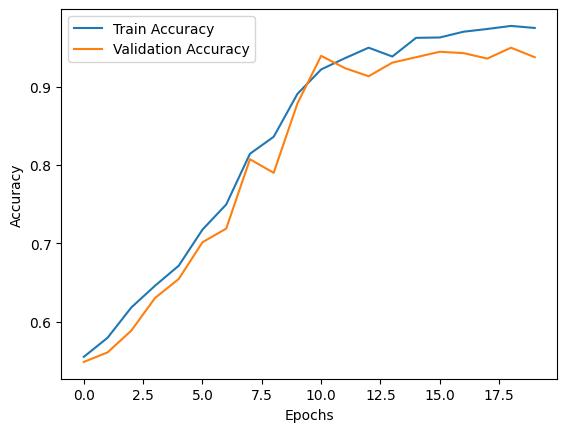

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.models import save_model

# Save the trained model
model.save("model_name.h5")


In [ ]:
import numpy as np
import soundfile as sf
import librosa

def preprocess_input(file_path, n_mfcc=40, max_length=None):
    """Preprocess the user-provided audio file for prediction."""
    try:
        # Load audio file
        audio, sample_rate = sf.read(file_path)
        if audio.ndim > 1:  # Convert stereo to mono
            audio = np.mean(audio, axis=1)

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)

        # Pad or truncate MFCCs to match max_length
        if max_length:
            if mfccs.shape[1] < max_length:
                mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
            else:
                mfccs = mfccs[:, :max_length]

        # Add batch and channel dimensions
        mfccs = np.expand_dims(mfccs, axis=-1)  # Add channel dimension
        mfccs = np.expand_dims(mfccs, axis=0)   # Add batch dimension

        return mfccs
    except Exception as e:
        print(f"Error processing input file: {e}")
        return None

def predict_user_input(model, file_path, max_length):
    """Make a prediction on the user-provided audio file."""
    # Preprocess the input
    processed_input = preprocess_input(file_path, max_length=max_length)
    if processed_input is None:
        return "Error: Could not process the input file."

    # Predict using the model
    prediction = model.predict(processed_input)

    # Convert prediction to class label
    predicted_class = "Confidence" if prediction[0][0] > 0.5 else "No Confidence"
    return predicted_class


In [ ]:
# Example: Predicting on a user-provided file
user_file_path = "/content/Actor_07/03-01-01-01-01-01-07.wav"  # Replace with the actual file path
prediction = predict_user_input(model, user_file_path, max_length)
print(f"Prediction: {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: No Confidence
